In [57]:
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from myutils import *  # restore(), get_filename()
import ptrReader
import pytools as pt
#from particle_tracer import sample_evdf         # CAUSES AN ERROR? seemingly related to the argument parser
from copy import deepcopy
#import os
#os.environ['PATH'] = "/wrk-vakka/group/spacephysics/proj/appl/tex-basic/texlive/2023/bin/x86_64-linux:" + os.environ['PATH']
#print(os.environ["PATH"])

R_EARTH = 6.371e6




In [58]:
# copied directly from utils/particle_tracer.py, because importing didn't work

def sample_evdf(vlsvReader, x, v):
    '''
    given a vlsvReader object, find the value of the distribution function f
    at a given coordinate in position/velocity phase space: f(x,v)
    assumes a maxwellian f, and polytropic equation of state (adiabatic index 5/3)

    Inputs:
    x: position vector [m], 3-element array
    v: velocity vector [m/s], 3-element array
    '''
    gamma = 5. / 3.
    if vlsvReader.get_config() is None:
        # Generally, it should be possible to find parameters with vlsvReader.get_config().
        # Tested: FHA works, but not EGL
        n0 = 1e6              # EGI, EGL, FHA [m^-3]. 
        T0 = 1.380649e-23 * 5e5         # EGI, EGL [Joules]
        vbulk = np.array([-7.5e5, 0, 0])
    else:
        n0 = float(vlsvReader.get_config()['proton_Magnetosphere']['rho'][0])
        T0 = 1.380649e-23 * float(f.get_config()['proton_Magnetosphere']['T'][0])
        vbulk = np.array([f.get_config()['proton_Magnetosphere']['VX0'][0],
                          f.get_config()['proton_Magnetosphere']['VY0'][0],
                          f.get_config()['proton_Magnetosphere']['VZ0'][0]])
    C = T0 * n0**(1. - gamma)
    v_plasma = v - vbulk  # velocity vector in plasma frame
    v_mag = np.sqrt( v_plasma[0]**2 + v_plasma[1]**2 + v_plasma[2]**2 )
    m_e = 9.10938e-31
    '''
    # interpolate to the plasma parameters at the final position
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    T = C * n**(gamma - 1.)
    vbulk = vlsvReader.read_interpolated_variable('proton/vg_v', x)
    f = n * (m_e / (2 * np.pi * T))**1.5 * np.exp(-m_e * v_mag**2 / (2 * T))
    '''
    f = n0 * (m_e / (2 * np.pi * T0))**1.5 * np.exp(-m_e * v_mag**2 / (2 * T0))
    return f




In [59]:
# Read Lorentziator simulation data, from range of times

def read_lorentziator_ptr_as_dct(ptrdir, metadata_file):
    '''
    path [str]: path to ptr files 
        example: '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'
    metadata_file [str]: the .pck file describing the velocity grid, time step, etc.
        example: '{ptrdir}/metadata.pck'
    '''
    import ptrReader

    mdct = restore(metadata_file)
    nv = mdct['nv']
    vmin = mdct['vmin']
    vmax = mdct['vmax']
    dv = (vmax - vmin) / (nv-1.)
    run = mdct['run']
    fileIndex = mdct['fileIndex']
    vpar, vperp = np.meshgrid( np.arange(vmin, vmax+dv, dv), np.arange(vmin,vmax+dv, dv), indexing='ij')
    t = mdct['t']
    start_ti = 0
    #end_ti = nt - 1
    #nt = t.size
    end_ti = 300              # for testing, with fewer files
    nt = end_ti - start_ti + 1   # ''

    xl = np.zeros([nv, nv, nt, 3])
    vl = np.zeros([nv, nv, nt, 3])

    nt_actual=0
    for ti in range(start_ti, end_ti+1):
        try:
            print(ti)
            p = ptrReader.read_ptr_file('{}population.{}.ptr'.format(ptrdir, str(ti).zfill(7)))
            xl[:,:,ti,:] = p.pos().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)
            vl[:,:,ti,:] = p.vel().reshape([nv,nv,3])   # shape (nv^2, 3) -> (nv,nv,3)
            nt_actual+=1
        except:
            print('index {} does not exist'.format(ti))

    xl = xl[:,:,0:nt_actual,:]
    vl = vl[:,:,0:nt_actual,:]
    t=t[0:nt_actual]

    x_i = xl[:,:,0,:]
    v_i = vl[:,:,0,:]
    x_f = xl[:,:,-1,:]
    v_f = vl[:,:,-1,:]

    # Liouville map the final positions
    f = np.zeros(vpar.shape)
    filename = get_vlsvfile_fullpath(run, fileIndex)
    vlsvReader = pt.vlsvfile.VlsvReader(filename)
    for i in range(nv):
        print('i = {}/{}'.format(i, nv))
        for j in range(nv):
            f[i,j] = sample_evdf(vlsvReader, x_f[i, j, :], v_f[i, j, :])

    dct = { 'f':f, 'vpar':vpar, 'vperp':vperp, 'x_i':x_i, 'v_i': v_i, 'x_f': x_f, 'v_f': v_f, 'x':xl, 'v':vl, 't':t, 'filename':filename,
           'run': run, 'fileIndex': fileIndex, 'nv': nv}

    return dct




In [60]:
# READ DATA (particle_tracer.py or lorentziator)

# === particle_tracer.py ====


run = 'EGI'   # 'EGL'
nv = 8
fileIndex = 1506

##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x10.5_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.0_y0.0_z0.0.pickle")
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y0.0_z0.0.pickle")  # vmax = 1e7
##d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_60000_x11.5_y1.0_z0.0.pickle")
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1506_electron_nt_80000_x11.5_y0.0_z0.0.pickle")  # vmax = 5e6 (zoomed in)
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1505_electron_nt_120000_x13.0_y0.0_z0.0_intptime0_odeint.pickle")
d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/test_convergence/BorisA/x13_n160000_t1300/f_liouville_test_EGI_1300_electron_nt_160000_x13.0_y0.0_z0.0_intptime1_BorisA_res1.02e+03.pickle")


# v HAVEN'T CHECKED OUT THIS FILE YET v
#fileIndex = 1199
#d = restore("/wrk-vakka/users/horakons/carrington/data/particle_tracer/f_liouville_test_EGI_1199_electron_nt_22000_x13.0_y0.0_z0.0.pickle")  # vmax = 2e7
'''


# === lorentziator (.ptr output files) ====

#ptrdir ='/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'   # vmax = 2e7
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x13RE/'   # vmax = 5e6
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x11.5RE/'   # vmax = 5e6
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol100/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_100/'   
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol10/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   
#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1500_1200_Nv256_x13_gpu/' # vmax = 1e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   
ptrdir = '/wrk-vakka/users/kpapadak/lorentziator/test_configs/' # vmax = 1e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   

metadata_file = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1500_1200_Nv256_x13_gpu/metadata.pck'
#metadata_file = ptrdir + 'metadata.pck'


d = read_lorentziator_ptr_as_dct(ptrdir, metadata_file)

run = d['run']
fileIndex = d['fileIndex']
nv = d['nv']
'''


"\n\n\n# === lorentziator (.ptr output files) ====\n\n#ptrdir ='/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1188_x13RE/'   # vmax = 2e7\n#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x13RE/'   # vmax = 5e6\n#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1199_1159_x11.5RE/'   # vmax = 5e6\n#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol100/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_100/'   \n#ptrdir = '/wrk-vakka/users/horakons/carrington/data/lorentziator/electron/EGI_1505.5_1450_x11.5_gpu_tol10/' # vmax = 2e7. NOTE: screwed up the initial velocity array, interpolated to t=1199 by accident.  Copied from /wrk-vakka/users/kpapadak/lorentziator/test_configs/tol_10/'   \n#ptrdir = '/wrk-vakka/users/horakons/car

In [61]:
d.keys()
#np.where(np.isfinite(d['f']))
#np.nanmax(d['f'])



dict_keys(['run', 'fileIndex', 'f', 'vpar', 'vperp', 'x_i', 'v_i', 'x_f', 'v_f', 'x', 'v', 't', 't_phys', 'time_sign', 'method', 'res', 'filename'])

07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral
07-Aug-24 15:59:19: Substituting symbol \perp from STIXGeneral


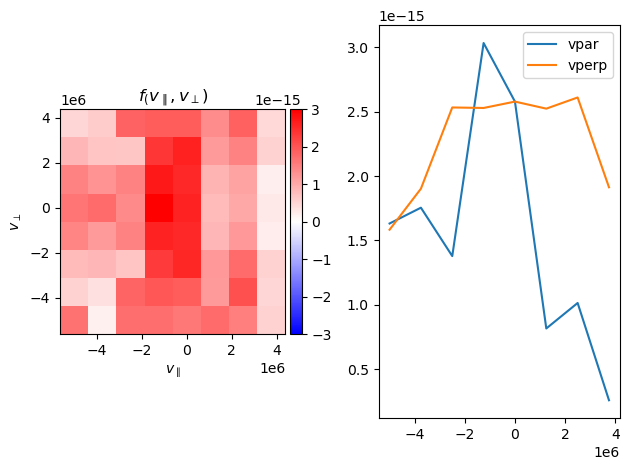

In [62]:
# Note He et al. ( https://doi.org/10.3847/1538-4357/ab9174 ) claim Tpar > Tperp due to dissipation of turbulence... could this just be adiabatic?  
# For instance: "In contrast, the electrons exhibit remarkable thermal anisotropy with Te_par > Te_perp at most times."

# See Tran & Sironi (2024) for electron simulations at a shock  --- very similar to what I'm trying to do
# "Electron Heating in 2D Particle-in-cell Simulations of Quasi-perpendicular Low-beta Shocks"
# Tran & Sironi wrote another very similar paper in 2020
# see also Sironi & Tran 2024 for another application

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


f = d['f']; vpar = d['vpar']; vperp = d['vperp']; x_f = d['x_f']; v_f = d['v_f']
r_f = np.linalg.norm(x_f, axis=-1)
r_f_mask = (r_f < 17*R_EARTH) # | (r_f > 28*R_EARTH)
f_masked = deepcopy(f)
f_masked[r_f_mask] = -1e-15

filename = d['filename']; x = d['x']; v =d['v']

fig, ax = plt.subplots(1,2)

im = ax[0].pcolormesh(vpar, vperp, f_masked,
                   cmap='bwr', shading='auto', vmin=-3e-15, vmax=3e-15)
ax[0].set_xlabel(r'$v_\parallel$')
ax[0].set_ylabel(r'$v_\perp$')
ax[0].set_title(r'$f_(v_\parallel, v_\perp)$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mycbar = fig.colorbar(im, cax=cax, orientation='vertical')

ax[1].plot(vpar[:,nv//2], f_masked[:,nv//2], label = 'vpar')
ax[1].plot(vperp[nv//2,:], f_masked[nv//2,:], label = 'vperp')
ax[1].legend()
ax[0].set_aspect('equal')
plt.tight_layout()
plt.show()
#mycbar = ax.figure.colorbar(im)


In [63]:
x_f.shape
#x[0][0].shape


(8, 8, 3)

In [64]:

ni = f.shape[0]
nj = f.shape[1]
v_i_mag = np.zeros(f.shape)
v_f_mag = np.zeros(f.shape)
x_i = np.zeros(x_f.shape)

for i in range(ni):
    for j in range(nj):
        v_i_mag[i, j] = np.linalg.norm(v[i][j][0,:])
        v_f_mag[i, j] = np.linalg.norm(v_f[i,j,:])
        x_i[i,j,:] = x[i][j][0,:]
#v_i_mag = np.sqrt(vpar**2 + vperp**2)


energy_i = 0.5 * 9.1e-31 * v_i_mag**2 / 1.6e-19    # eV
energy_f = 0.5 * 9.1e-31 * v_f_mag**2 / 1.6e-19    # eV
energy_f

array([[ 17.68798044,  68.72508342,  52.8354596 ,  30.54899911,
         28.25874534,  31.44143472,  49.76296742,  71.07532381],
       [130.7466797 ,  86.17338343,  62.07956508,  39.50470096,
         25.17619111,  36.14125368,  59.16249806,  81.20289413],
       [ 15.13477206,  23.48885137,  68.61671729,  35.91344821,
         35.52117806,  30.15501244,  72.38927915,  28.93551452],
       [ 32.12451008,  24.64436826,   7.46774809,  10.96645912,
          1.79512755,   7.70551863,   8.66518438,  14.39571227],
       [ 18.58595671,  29.24800875,   3.32561462,  12.09972461,
          8.73426853,   7.19269723,  11.16703589,  25.36435534],
       [ 33.80388791,  33.40465354,  43.37674026,  57.11175482,
         57.89398582,  53.6442869 ,  42.85070671,  31.84858563],
       [ 35.09551116,  25.26707565,  19.1255484 ,  43.80200577,
         48.58870067,  48.6236241 ,  35.03097195,  13.76470644],
       [ 83.01697238,  70.900507  ,  74.7125428 , 112.87870282,
        106.89107998, 119.7728031

In [65]:
(energy_f - energy_i)[0,:]

array([-124.27635885,  -42.13258929,  -35.80226529,  -44.7554967 ,
        -42.59924014,  -43.85675918,  -38.86215366,  -39.76344319])

In [66]:
x_f[3,5,:] / 6.371e6

array([19.13254885, -0.05026643,  3.57776824])

In [67]:
print(vperp[0,:])
print(vpar[0,:])

[-5000000. -3750000. -2500000. -1250000.        0.  1250000.  2500000.
  3750000.]
[-5000000. -5000000. -5000000. -5000000. -5000000. -5000000. -5000000.
 -5000000.]


In [68]:
energy_i

array([[1.41964339e+02, 1.10857673e+02, 8.86377249e+01, 7.53044958e+01,
        7.08579855e+01, 7.52981939e+01, 8.86251211e+01, 1.10838767e+02],
       [1.10950496e+02, 7.98438289e+01, 5.76238811e+01, 4.42906520e+01,
        3.98441417e+01, 4.42843501e+01, 5.76112773e+01, 7.98249232e+01],
       [8.88233705e+01, 5.77167039e+01, 3.54967561e+01, 2.21635270e+01,
        1.77170167e+01, 2.21572251e+01, 3.54841523e+01, 5.76977982e+01],
       [7.55829642e+01, 4.44762976e+01, 2.22563498e+01, 8.92312072e+00,
        4.47661039e+00, 8.91681882e+00, 2.22437460e+01, 4.44573919e+01],
       [7.12292767e+01, 4.01226101e+01, 1.79026623e+01, 4.56943319e+00,
        1.22922866e-01, 4.56313129e+00, 1.78900585e+01, 4.01037044e+01],
       [7.57623079e+01, 4.46556413e+01, 2.24356935e+01, 9.10246441e+00,
        4.65595409e+00, 9.09616251e+00, 2.24230897e+01, 4.46367356e+01],
       [8.91820579e+01, 5.80753913e+01, 3.58554435e+01, 2.25222144e+01,
        1.80757041e+01, 2.25159125e+01, 3.58428397e+01, 5.

Text(0, 0.5, 'final energy')

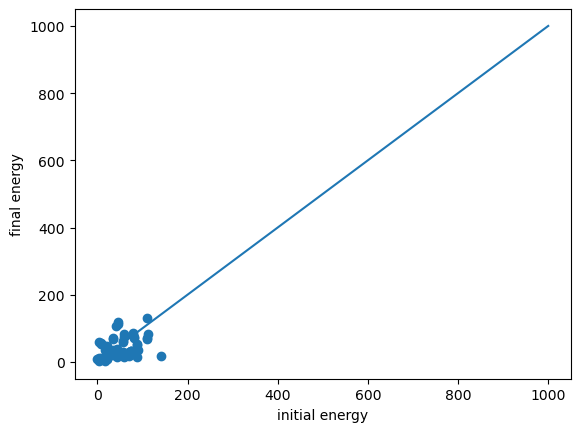

In [69]:
plt.scatter(energy_i, energy_f)
plt.plot([0,1000], [0,1000])
plt.xlabel('initial energy')
plt.ylabel('final energy')


In [70]:
# calculate the electric potential in the solar wind region
filename = get_filename(run, fileIndex)


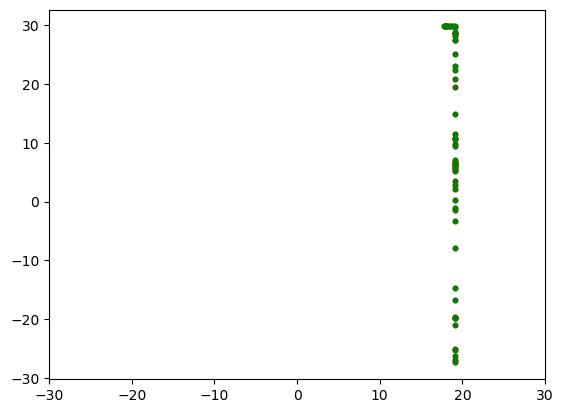

array([[ -3.32033509,  29.82263521,  29.82263722,  28.96030044,
         27.50022234,  28.67788987,  29.82263604,  29.82263471],
       [ 29.82263735,  29.8226358 ,  29.82263484,  28.68769964,
         23.06605401,  27.56791437,  29.82263872,  29.82263794],
       [ -7.86856618,   7.09851971, -26.92915689, -19.64061785,
        -20.94447274, -19.76270966, -27.40104065,   6.68789025],
       [  6.60501648,   9.76624755,   5.94050632,   5.3425495 ,
         -1.44774785,   3.57776824,   5.25301319,  10.76305832],
       [  9.5239645 ,  10.60973221,   2.15556335,   6.17330637,
          6.59045036,   6.24196456,   0.21779379,  10.61601995],
       [ -1.04896403, -16.72383199, -19.83208633, -25.34982168,
        -26.31571091, -25.07520379, -19.80952894, -14.65613475],
       [  5.48108858,   2.75689092,  11.48938928,  19.58749249,
         22.37952283,  20.92329901,  14.86921058,   5.9551127 ],
       [ 25.20748546,  28.1583532 ,  29.69599096,  29.82263629,
         29.82263773,  29.8226392

In [71]:

# maybe this only works when run with sbatch
# the idea is to plot the magnetosphere, and the initial and final points 
'''
import pytools as pt
ax = plt.gca()
pt.plot.plot_colormap3dslice(filename=filename,var='proton/vg_rho', boxre=[-20, 20, -20, 20], normal ='z', run=run,
                             colormap='plasma',step=fileIndex,outputdir='/wrk-vakka/users/horakons/carrington/plots/{}/ptest/'.format(run),
                             outputfile='vg_rho_particle_trace_{}_{}.png'.format(run, str(fileIndex).zfill(5)),
                             Earth=1, streamlines='vg_b_vol', streamlinedensity=1, streamlinecolor = 'white', cutpointre=0, axes = ax, scale=1, useimshow=True)
'''

r_f_mask3 = np.repeat(r_f_mask[:,:,None], 3, axis=2)
x_f_mask_x = deepcopy(x_f[:,:,0])
x_f_mask_x[r_f_mask] = None
x_f_mask_y = deepcopy(x_f[:,:,1])
x_f_mask_y[r_f_mask] = None
x_f_mask_z = deepcopy(x_f[:,:,2])
x_f_mask_z[r_f_mask] = None



#plt.scatter(x_f[:,:,0]/R_EARTH, x_f[:,:,1]/R_EARTH)   # x-y
plt.scatter(x_f[:,:,0]/R_EARTH, x_f[:,:,2]/R_EARTH, s =10, color = 'red')  # x-z
plt.scatter(x_f_mask_x/R_EARTH, x_f_mask_z/R_EARTH, s =10, color = 'green')  # x-z

plt.xlim([-30,30])

plt.show()
x_f[:,:,2]/R_EARTH

In [76]:
'''
# plot trajectory of 1 particle in physical space, DEBUG
i = nv//2 +10
j = nv//2 +10
#t_inds = range(50)   
t_inds = list(range(d['t'][0][0].size)) # 100

#plt.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
#plt.plot(x[i][j][0:100,0]/R_EARTH, x[i][j][0:100,2]/R_EARTH)  # x-z   (to show larmor motion)
plt.plot(x[i][j][t_inds,0]/R_EARTH, x[i][j][t_inds,2]/R_EARTH)

#plt.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z
'''

IndexError: list index out of range

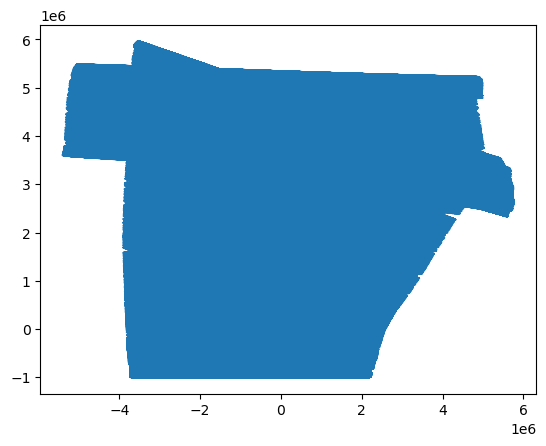

In [80]:
# plot trajectory of 1 particle in velocity space
i = 0#nv//2 +1
j = 0#nv//2 +1
#t_inds = range(50)   
t_inds = range(d['t'][0][0].size)  # 100

#plt.plot(v[i][j][:,0], v[i][j][:,1])  # x-y
plt.plot(v[i][j][t_inds,0], v[i][j][t_inds,2])
#plt.plot(v[i][j][:,1], v[i][j][:,2])  # y-z

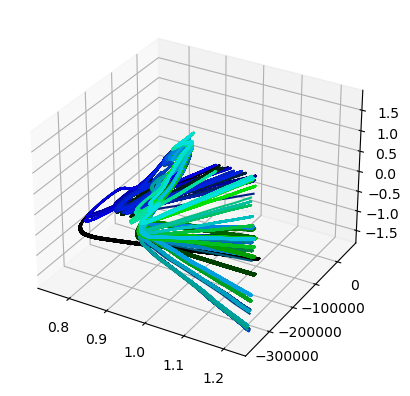

In [81]:
fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
for i in range(nv):
    for j in range(nv):
        # 3D
        ax.plot(x[i][j][:,0], x[i][j][:,1], x[i][j][:,2], color = (0, i/nv, j/nv))  # x-z


plt.show()
plt.close()

Found population proton


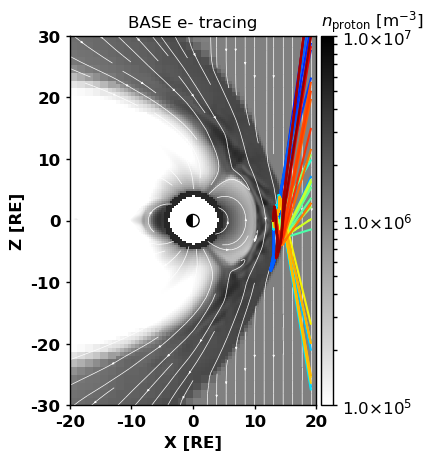

In [83]:
import pytools as pt
import matplotlib.pyplot as plt
import ftest as ft
from static_field_tracer_3d import static_field_tracer_3d
import numpy as np
from myutils import *    #e.g. this imports get_vlsvfile_fullpath, mkdir_path, cartesian_to_spherical, spherical_to_cartesian, ...

run = 'EGL'            #doesn't work?
dim = '3D'
bulk = 'bulk1.egl'

# Defining source and output file locations
#bulkLocation = '/wrk/group/spacephysics/vlasiator/{}/{}/bulk/'.format(dim, run)
outputLocation = '/wrk/users/horakons/test/test_analysator/'


run='EGI'
fileIndex = 1300
filename = get_vlsvfile_fullpath(run, fileIndex)

ax = plt.gca()
normal = 'y'     # y=0 plane
pt.plot.plot_colormap3dslice(filename=filename,var='proton/vg_rho', boxre=[-20,20,-30,30], normal =normal,
        run=run,colormap='binary',vmin=1e5,vmax=1e7,step=j,outputdir=outputLocation,
        outputfile='test_colormap_3dslice_temperature_{}eq0_{}_{}.png'.format(normal, run, fileIndex),
        Earth=1,streamlines = 'vg_b_vol', cutpointre=0, axes = ax, useimshow=True, scale=1.5)


#pt.plot.plot_colormap3dslice(filename=bulkname,var=plotvar, boxre=[-11, 11, -11, 11], normal =normal, run=run,
#                             colormap='seismic',vmin=vmin,vmax=vmax,step=j,outputdir=outputLocation,
#                             outputfile='beta_star_colormap_xy_{}_{}.pdf'.format(run, str(j).zfill(5)),
#                             Earth=1, streamlines=streamlines, streamlinedensity=sl_density, streamlinethick = streamlinethick, streamlinecolor = sl_color, 
#                             cutpointre=0, axes = ax, scale=scale, useimshow=True)


#fig, ax = plt.subplots()

n = 64
colors = plt.cm.jet(np.linspace(0,1,n))

for i in range(1,8):
    for j in range(1,7):
        # ALL POSITIONS
        #ax.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,1]/R_EARTH)  # x-y
        #ax.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,2]/R_EARTH, color = plt.cm.jet((0, i/nv, j/nv)))  # x-z
        ax.plot(x[i][j][:,0]/R_EARTH, x[i][j][:,2]/R_EARTH, color = colors[i*nv+j])  # x-z
        #ax.plot(x[i][j][:,1]/R_EARTH, x[i][j][:,2]/R_EARTH)  # y-z
        # FINAL POSITION
        #ax.scatter(x[i][j][-1,0]/R_EARTH, x[i][j][-1,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z


'''
#just two trajectories
ax.plot(x[7][4][:,0]/R_EARTH, x[7][4][:,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z
ax.plot(x[0][4][:,0]/R_EARTH, x[0][4][:,2]/R_EARTH, color = (0, i/nv, j/nv))  # x-z
'''

#ax.scatter(x[i][j][0,0]/R_EARTH, x[i][j][0,2]/R_EARTH, color = 'orange', s =200)
ax.set_xlabel('X [RE]')
ax.set_ylabel('Z [RE]')
#ax.set_xlim([12.5,13.5])


#ax.set_title('Backwards trajectories starting at {} (nonlocality)'.format(x[0][0][0,:]/R_EARTH))
ax.set_title('BASE e- tracing'.format(x[0][0][0,:]/R_EARTH))
#ax.set_aspect(0.5) #'equal'
plt.savefig('/wrk-vakka/users/horakons/proposals/BASELINE_e_backtrace.pdf')

In [ ]:

def phi_gradP(x, vlsvReader, n0 = 1e6):
    '''
    Inputs:
     x: 3-element coordinate vector or list
     vlsvReader: vlsvReader object

     PhiGradPe returns the potential Phi based on the density.
     Note when electrons follow adiabatic equation of state (EOS)
     grad Pe field is a potential field.
     Initial electron parameters (n0, T0) that set the EOS
     are found in .cfg file. But this function works for EGL, EGI, FHA

     Note: in EGL (and FHA?) n0=1e6 at early times and n0 = 4e6 at the end
    '''    
    elementalcharge = 1.6021773e-19
    kb = 1.38065e-23
    n = vlsvReader.read_interpolated_variable('proton/vg_rho', x)
    gamma = 5. / 3.
    T0 = kb * 5e5         # EGI, EGL [Joules]
    C = T0 * n0**(1. - gamma)
    return -(C / elementalcharge) * (gamma / (gamma - 1.)) * ( n**(gamma-1.) - n0**(gamma-1.) )


vlsvReader_file = get_vlsvfile_fullpath(run, fileIndex)
import ftest as ft
vlsvReader = ft.f(vlsvReader_file)

#phi_gradP(x_f[0,1], vlsvReader)
phi_gradP([13.5*R_EARTH,0,0], vlsvReader, n0 = 1e6)



In [ ]:
def phi_ExB(x, vlsvReader, x0 = [0,0,0], v0 = [-7.5e5, 0, 0], B0 = [0, 0, -5e-9]):
    #E would be nice to read the input data with vlsvReader.get_config(), but that doesn't seem to be working for EGI/EGL
    #measure ExB potential at x, with respect to the position x0, assuming uniform v and B fields 
    E_convec = -np.cross(np.array(v0), np.array(B0))  # for EGL, in +y direction
    deltax = np.array(x) - np.array(x0)
    return -np.dot(deltax, E_convec)


phi_ExB([11.5*R_EARTH, 0.01*R_EARTH,0], vlsvReader)   # for EGL, EGI, FHA, only the y-component matters


In [ ]:
print( phi_ExB(x_f[3,3], vlsvReader) )
print( phi_gradP(x_f[3,3], vlsvReader, n0 = 1e6) )
phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6) 
phi_ExB(x_i[i,j], vlsvReader) 



In [ ]:
phi1 = phi_ExB(x_f, vlsvReader)
phi1 = phi1 - phi1[4,4]   # subtract the potential of the electron with v_i = 0, assumed to be moving on an equipotential
phi2 = phi1 * 0
for i in range(nv):
    for j in range(nv):
        phi2[i,j] = phi_gradP(x_f[i,j], vlsvReader, n0 = 1e6)  - phi_gradP(x_i[i,j], vlsvReader, n0 = 1e6)    

phi_tot = phi1 + phi2    # electric potential [volts]. Note phi2 is given as diff. between locations x_f and x_i, while phi1 is given as a presumed potential wrt a reference y-location. Note the ExB leading to phi1 is not required to be a potential field

phi1[4,4]

In [ ]:
delta_energy = energy_f - energy_i
plt.close()
plt.scatter(delta_energy, phi_tot)

In [ ]:
phi1
phi2

In [ ]:
phi_gradP(x_i[5,5], vlsvReader, n0 = 1e6)

In [ ]:
plt.plot(x_f[:,:,1], phi1)
plt.show()

In [ ]:
x[0,0][106,:]/R_EARTH

In [ ]:
np.where(r_f_mask == True)

In [ ]:
r_f/R_EARTH

In [ ]:
f[r_f_mask]

In [ ]:
viridis()

In [ ]:
vpar

In [79]:
d['t'][0][0]


array([0.00000e+00, 5.00000e-04, 1.00000e-03, ..., 7.99990e+01,
       7.99995e+01, 8.00000e+01])